# pyLMP : Python Lee Model for Dense Plasma Focus

## Section 1: Device and Taper Selection

In [2]:
#Essential imports
import sys
import numpy
import math
#Non essential imports (for plotting and data wranggling)
import matplotlib.pyplot as plt
import numpy as np
import pandas
#piclayer
import piclayer

#TAPER, default no taper
TAPER = 0
TAPERSTART = 15
ENDRAD = 16
device = '0'

if device == '0':
#'UNUICTPPFF':
    L0 = 110
    C0 = 30
    RADB = 3.2
    RADA = 0.95
    Z0 = 16
    R0 = 12
    V0 = 15
    P0 = 3.5
    MW = 4
    #atomic z number, just H plasma
    ZN = 1
    dissociatenumber = 2
    massf = 0.08
    CURRF = 0.7
    massfr = 0.16
    currfr = 0.7
if device == '1':
#'NX2-RGNeon':
    L0 = 20
    C0 = 28
    RADB = 4.1
    RADA = 1.9
    Z0 = 5
    R0 = 2.3
    V0 = 11
    P0 = 2.63
    MW = 20
    ZN = 10
    dissociatenumber = 1
    massf = 0.0635
    CURRF = 0.7
    massfr = 0.16
    currfr = 0.7
if device == '2':
#'PF1000 27D':
    L0 = 33
    C0 = 1332
    RADB = 16
    RADA = 11.55
    Z0 = 60
    R0 = 6.3
    V0 = 27
    P0 = 3.5
    MW = 4
    ZN = 1
    dissociatenumber = 2
    massf = 0.14
    CURRF = 0.7
    massfr = 0.35
    currfr = 0.7




## Common and Scaling Parameters
G = specific heat ratio.  
RADB = OUTER RADIUS (in m, for calculations in real quantities)  
RADA = INNER RADIUS (in m,  ditto )  
Z0   = LENGTH OF ANODE (in m, ditto)   
C    = RADB/RADA.   
F    = Z0/RADA.   
L0   = CIRCUIT STRAY INDUCTANCE (in HENRY, ditto).  
C0   = ENERGY STORAGE CAPACITANCE (in FARAD, ditto).   
AL= capacitor time T0/TA, axial run-down time.  
BE= full axial phase inductance LZ0/L0.  
MASSF= REDUCED MASS FACTOR DUE TO MASS SHEDDING.   
CURRF= REDUCED CURRENT FACTOR DUE TO CURRENT SHEDDING.   
R0 IS STRAY CIRCUIT RESISTANCE IN OHM   
RESF=R0/Surge Impedance   
Z1 is end position, to end calculation of phase 5.  
MASSF, MASSFR are incorporated in TA & AL & in AA.  
CURRF IS INcorporated into BE.  
For Phase I calculations, T = Time, Z = Axial position (normalized to Zo).   
I = Current, ZZ = Speed, AC = Acceleration.  
II = Current derivative, I0 = Current Intergral, all normalized.   
HOWEVER ALL QUANTITIES WITH An R ATTACHED, HAVE BEEN RE-COMPUTED TO GIVE LABORATORY VALUES; e.g. TR IS TIME RE-COMPUTED IN MICROSEC;IR IS CURRENT RE-COMPUTED IN kA AND SO ON.  
D = Time increment, V = tube voltage, all normalized.   


In [3]:
ENDFLAG = 0
DFLAG = 0
DVFLAG = 0
NTN = 0
NBN = 0
NN = 0
VRMAX = 0
peakvs = 0
peakvp = 0
tc5 = 1

R0 = R0 / 1000
#Setting consts
#magnetic permitivity of vaccum, Henry per meter 
MU = 1.257e-6
# \pi
Pi = 3.142
#boltzman const
bc = 1.38e-23
#mass of proton
mi = 1.67e-27
MUK = MU / (8*Pi*Pi*bc)
CON11 = 1.6e-20
CON12 = 9.999999e-21
CON2 = 4.6e-31
UGCONS = 8.310001e3
FRF = 0.3
fe = 1 / 3
FLAG = 0

#Rem reset EINP, energy dissipated by dynamic resistance effect, 
#resistance for non-ohmic materials, generally r = dV/dI. which is 0.5 (Ldot) I^2, 
#generally r =  considering current taking part in the motion

#gamma = specific heat ratio, was just 'g' in original vbs

if ZN <= 2:
    gamma = 1.66667
else: #If Ne or argon or Xenon, Kr or N2, set approx initial values of G
    gamma = 1.3
#G1 is current sheet speed slower factor
G1 = 2/ (gamma + 1)
G2 = (gamma - 1) / gamma
#Compression ratio of ambient gas swept up by shock front 
GCAP = (gamma + 1) / (gamma - 1)

# Calculate ambient atomic number density (no of atoms per m^2)and some ratios
# For PF operation assume all molecules are completely dissociated in all phases

# N0= number of atoms per m^2; atomic number density
N0 = dissociatenumber * 2.69e25 * P0 / 760
# C is ratio of cathode radius / anode radius
C = RADB / RADA
# Lee paper, page 8. Z0 is the length of anode, so f is ratio of anode length over it's radius
f = Z0 / RADA
# Convert to SI units
C0 = C0 * pow(10,-6)
#print(C0)
L0 = L0 * pow(10,-9)
RADB = RADB * 0.01
RADA = RADA * 0.01
Z0 = Z0 * pow(10,-2)
V0 = V0 * 1000
RHO = P0 * 2.33e-4 * MW / 4
TM = 0
#taper
TAPERSTART = TAPERSTART * 0.01
ENDRAD = ENDRAD * 0.01
zTAPERSTART = TAPERSTART / Z0
#Error shld be Z0 -zTAPERSTART
tapergrad = (RADA - ENDRAD) / (Z0 - TAPERSTART)
#Calculate characteristic quantities and scaling parameters
#Lee paper page 5, Voltage at t = 0 over surge impedence
I0 = V0 / numpy.sqrt(L0 / C0)
#Lee paper page 5, 
T0 = numpy.sqrt(L0 * C0)
#Scaling parameter for Axel Phase. Equation 5 on Lee Paper
#print(((Z0 * numpy.sqrt(RHO)) / (I0 / RADA)) * (numpy.sqrt(massf) / CURRF))
TA = numpy.sqrt(4 * Pi * Pi * (C * C - 1) / (MU * numpy.log(C))) * ((Z0 * numpy.sqrt(RHO)) / (I0 / RADA)) * (numpy.sqrt(massf) / CURRF)
#Lee papaer page 5, equation 7. zzchar is characteristic axial speed 
ZZCHAR = Z0 / TA
# AL : Alpha, ratio of characteristic electrical discharge time to the characteristic axial transit time
AL = T0 / TA
# Scaling Parameter for Radial Phase. Equation 24a, Lee paper page 8
AA = numpy.sqrt((gamma + 1) * (C * C - 1) / numpy.log(C)) * (f / 2) * (numpy.sqrt(massf / massfr)) * (currfr / CURRF)
# Ratio of stray resistance to surge impedence
RESF = R0 / (numpy.sqrt(L0 / C0))
#Lee paper page 5, equation 9. Ratio between inductance of the axial phase when CS reaches anode end z = z0, over Lo (inductance at t = 0) * current shedding factor, 
BE = 2e-7 * numpy.log(C) * Z0 * CURRF / L0
#Lee paper page 8, equation 24, Scaling parameter for Radial Inward Shock Phase
BF = BE / (numpy.log(C) * f)
#Lee paper page 8, equation 28, VPINCHCH is the speed of radial inward shock
VPINCHCH = ZZCHAR * AA / f
#convert speed of radial inward shock to time
TPINCHCH = RADA / VPINCHCH
#Calculate ratio of characteristic capacitor time to sum of characteristic axial & radial times
ALT = (AL * AA) / (1 + AA)


# Removed limitation to operate above 19 Torr

#Parameters sanity check
if ZN <= 2:
    if ALT <= 0.68:
        raise ValueError("Sorry ALT values are insane for Zn <= 2")
else: #Caters for ZN = 7,10,18,36,54
    if ALT <= 0.65:
        raise ValueError("Sorry ALT values are insane for Zn = 7,10,18,36 or 54")
    

#The important value holders for phases
#1 Axial array
axialphase = []
#1 init axial headers
axialmap= {}
#2 init the shock array
radialshock = []
#2 init the headers
radialshockmap = {}
#3 radialreflect array
radialreflect = []
#3 radialreflectmap
radialreflectmap ={}
#4 slow pinch
radiativemap = {}
radiative = []
pinch = {}
#5 end-of-line  
pinchradiate = []
pinchradiatemap = {}

## Helper function for calcuating heat ratio $\gamma$ and effective charge Z using Corona Model

In [4]:
def CalcGZ(ZN , TM, zFLAG, gFLAG):
    g = 1.66667
    zn = ZN
    if ZN == 7: #old label 1185
        #For N2 compute specific heat ratio g and effective charge z using polynomials fitted from Corona model
        if zFLAG ==1:
            z = 7
            if gFLAG == 1:
                g = 1.6667
    if ZN == 10: #old label 1010, Neon
        if TM > pow(10,8):
            g = 1.6667
            if TM > (7*pow(10,6)):
                zn = 10
            if TM > (2.3 * pow(10,6)):
                zn = 8 + 0.4255 * pow(10, -6) * (TM - 2.3 * pow(10, 6))
            if TM > (4.5 * pow(10,5)):
                zn = 8
            if TM > (4.5 * pow(10,4)):
                zn = 1.9 + 1.5 * pow(10, -5) * (TM - 4.5 * pow(10, 4))
            if TM > 15000:
                zn = 6.3e-05 * (TM - 15000)
    if ZN == 18: #old label 1050
        if TM > 1.5 * pow(10, 8):
            g = 1.66667
        if TM > 1.2 * pow(10, 7):
            g = 1.54 + 9 * pow(10, -10) * (TM - 1.2 * pow(10, 7))
        if TM > 1.9 * pow(10, 6):
            g = 1.31 + 2.6 * pow(10, -8) * (TM - 1.9 * pow(10, 6))
        if TM > 9.3 * pow(10, 5):
            g = 1.3
        if TM > 5.7 * pow(10, 5):
            g = 1.34 - 1.6 * pow(10, -7) * (TM - 5.7 * pow(10, 5))
        if TM > pow(10, 5):
            g = 1.17 + 3.8 * pow(10, -7) * (TM - pow(10, 5))
        if TM > 1.3 * pow(10, 4):
            g = 1.15 + 2.3 * pow(10, -7) * (TM - 1.3 * pow(10, 4))
        if TM > 9000:
            g = 1.66667 - 1.29 * pow(10, -4) * (TM - 9000)
    if ZN == 36: #old label 1190
        if zFLAG == 1:
            zn = 36
        if gFLAG == 1:
            g = 1.6667
    if ZN == 54: #old label 1150
        #Table of G for ARGON; pre-calculated from Corona Model
        if TM > 1.5 * pow(10, 8):
            g = 1.66667
        if TM > 1.2 * pow(10, 7):
            g = 1.54 + 9 * pow(10, -10) * (TM - 1.2 * pow(10, 7))
        if TM > 1.9 * pow(10, 6):
            g = 1.31 + 2.6 * pow(10, -8) * (TM - 1.9 * pow(10, 6))
        if TM > 9.3 * pow(10, 5):
            g = 1.3
        if TM > 5.7 * pow(10, 5):
            g = 1.34 - 1.6 * pow(10, -7) * (TM - 5.7 * pow(10, 5))
        if TM > pow(10, 5):
            g = 1.17 + 3.8 * pow(10, -7) * (TM - pow(10, 5))
        if TM > 1.3 * pow(10, 4):
            g = 1.15 + 2.3 * pow(10, -7) * (TM - 1.3 * pow(10, 4))
        if TM > 9000:
            g = 1.66667 - 1.29 * pow(10, -4) * (TM - 9000)
            
    return g, zn

## Helper function for calcuating heat ratio $\gamma$ and effective charge Z using Corona Model

In [5]:
def CalcGZLog(ZN, TM, zFLAG, gFLAG):
    g = 1.66667
    zn = ZN
    
    if ZN <= 2:
        return g, zn
    
    if ZN == 7: #GoTo 4210
        #For nitrogen
        if zFLAG == 1:
            #For N2 Compute specific heat ratio g and effective charge z using polynomials fitted from Corona model
            z = 7
            if gFLAG == 1:
                g = 1.6667
    if ZN == 10: #goto 4110
        #Table for Neon
        if TM > pow(10, 8): #goto 4120
            g = 1.66667        
        if TM > 2 * pow(10, 7): #goto 4122
            g = 1.6 + 0.83 * pow(10, -9) * (TM - 2 * pow(10, 7))
        if TM > 4.5 * pow(10, 6): #GoTo 4124
            g = 1.47 + 0.84 * pow(10, -8) * (TM - 4.5 * pow(10, 6))
        if TM > 2.3 * pow(10, 6): #Then GoTo 4126
            g = 1.485
        if TM > 3.4 * pow(10, 5): #GoTo 4127
            g = 1.23 + 1.2 * pow(10, -7) * (TM - 3.4 * pow(10, 5))
        if TM > 2.4 * pow(10, 4): #4128
            g = 1.18
        if TM > 7 * pow(10, 6): #Then GoTo 4140
            zn = 10
        if TM > 2.3 * pow(10, 6): #Then GoTo 4143
            zn = 8 + 0.4255 * pow(10, -6) * (TM - 2.3 * pow(10, 6))
        if TM > 4.5 * pow(10, 5): #Then GoTo 4146
            zn = 8
        if TM > 4.5 * pow(10, 4): #Then GoTo 4147
            zn = 1.9 + 1.5 * pow(10, -5) * (TM - 4.5 * pow(10, 4))
        if TM > 15000: #Then GoTo 4148
            zn = 6.3 * numpy.exp(-5) * (TM - 15000)

    if ZN == 18: #Then GoTo 4150
        #ARGON
        if TM > 1.5 * pow(10, 8): #Then GoTo 4160
            g = 1.66667
        if TM > 1.2 * pow(10, 7): #Then GoTo 4161
            g = 1.54 + 9 * pow(10, -10) * (TM - 1.2 * pow(10, 7))            
        if TM > 1.9 * pow(10 ^ 6): #Then GoTo 4162
            g = 1.31 + 2.6 * pow(10, -8) * (TM - 1.9 * pow(10, 6))
        if TM > 9.3 * pow(10, 5): #Then GoTo 4163
            g = 1.3
        if TM > 5.7 * pow(10, 5): #Then GoTo 4164
            g = 1.34 - 1.6 * pow(10, -7) * (TM - 5.7 * pow(10, 5))            
        if TM > pow(10, 5): #Then GoTo 4165
            g = 1.17 + 3.8 * pow(10, -7) * (TM - pow(10, 5))
        if TM > 1.3 * pow(10, 8): #Then GoTo 4171
            zn = 18           
        if TM > 1.3 * pow(10, 7): #Then GoTo 4172
            zn = 16 + 1.8 * pow(10, -8) * (TM - 1.3 * pow(10, 7))
        if TM > 3.5 * pow(10, 6): #Then GoTo 4174
            zn = 16
        if TM > 4.7 * pow(10, 5): #Then GoTo 4175
            zn = 8 + 2.9 * pow(10, -6) * (TM - 4.7 * pow(10, 5))
        if TM > 2 * pow(10, 5): #Then GoTo 4176
            zn = 8
        if TM > 3.5 * pow(10, 4): #Then GoTo 4177
            zn = 2.2 + 3.5 * pow(10, -5) * (TM - 3.5 * pow(10, 4))
                    
    if ZN == 36: # GoTo 4250
        #For Krypton compute specific heat ratio g and effective charge z using polynomials fitted from Corona model
        if zFLAG == 1: 
            zn = 36
        if gFLAG == 1: 
            g = 1.6667
    
    if ZN == 54: #Then GoTo 4180
        #Xenon
        if TM > 9 * pow(10, 10):
            g = 1.66667
        if TM > 1.16 * pow(10, 9):
            g = 0.0053 * numpy.log(TeV) / numpy.log(10) + 1.631
        if TM > 1.01 * pow(10, 8): #Then GoTo 4183
            g = 0.063 * numpy.log(TeV) / numpy.log(10) + 1.342    
        if TM > 2.02 * pow(10, 7): # GoTo 4184
            g = 0.166 * numpy.log(TeV) / numpy.log(10) + 0.936
        if TM > 6.23 * pow(10, 6): #Then GoTo 4185
            g = 0.096 * numpy.log(TeV) / numpy.log(10) + 1.163            
        if TM > 9.4 * pow(10, 5): #Then GoTo 4186
            g = 0.1775 * numpy.log(TeV) / numpy.log(10) + 0.9404
        if TM > 3.3 * pow(10, 5): #Then GoTo 4187
            g = 1.27
        if TM > 6 * pow(10, 4): #Then GoTo 4188
            g = 0.122 * numpy.log(TeV) / numpy.log(10) + 1.093
        if TM > 1.2 * pow(10, 4): #Then GoTo 4189
            g = 1.17
        if TM > 8 * pow(10, 3): #Then GoTo 4190
            g = -2.624 * numpy.log(TeV) / numpy.log(10) + 1.229
        if TM > 9 * pow(10,10): #Then GoTo 4192
            zn = 54
        if TM > 2.85 * pow(10, 8): #Then GoTo 4193
            zn = 1.06 * numpy.log(TeV) / numpy.log(10) + 46.4
        if TM > 8.8 * pow(10, 7): #Then GoTo 4194
            zn = 10.72 * numpy.log(TeV) / numpy.log(10) + 3.99
        if TM > 2.11 * pow(10, 7): #Then GoTo 4195
            zn = 5.266 * numpy.log(TeV) / numpy.log(10) + 25.3
        if TM > 5.68 * pow(10, 6): #Then GoTo 4196
            zn = 25.23 * numpy.log(TeV) / numpy.log(10) - 40
        if TM > 3.35 * pow(10, 6): #Then GoTo 4197
            zn = 9.53 * numpy.log(TeV) / numpy.log(10) + 2.326
        if TM > 2.37 * pow(10, 5): #Then GoTo 4198
            zn = 15.39 * numpy.log(TeV) / numpy.log(10) - 12.1
        if TM > 10000: #Then GoTo 4199
            zn = 5.8 * numpy.log(TeV) / numpy.log(10) + 0.466

    return g, zn
            

# Phase 1: Axial Phase
## Main Equations used for this phase: 

### *Equation of current shealth motion (1)* 
$\frac{d^2}{dt^2} = \frac{[\frac{f_c^2 \mu(lnc)}{f_m4\pi^2\rho_o(c^2-1)}(\frac{I}{a})^2 - (\frac{dz}{dt})^2]}{Z}$    

This equation ties the rate of momentum change to the magnetic force. $f_c$ is the fraction of current flow in the current sheet (piston). f_mis the fraction of mass flowing in the piston. c is the ratio of cathode radius over anode radius. $\rho_o$ is the ambient density. $I$ is the time-dependent current. And $\mu$ is permeability.  

### *Equation of electric current (2)*
$\frac{dI}{dt} = [\frac{[V_0 - \frac{\int_ Idt}{C_0} - r_0I - If_c\frac{\mu}{2\pi}(lnc)\frac{dZ}{dt}]}{[L_0+\frac{f_c\mu}{2\pi}(lnc)Z]}$


$L_o$ is the initial time-dependent inductance. $C_O$ is the starting capacitance and, $V_o$ is the initial voltage.  

### *Equation of Motion (3)*
$\frac{d^2\zeta}{d\tau^2} = \frac{[\alpha^2\iota^2 - (\frac{d\gamma}{d\tau})^2]}{\zeta}$ 

  
This models plasma moving along length of the anode. Where $\zeta = \frac{z}{z_o}$ and $z_o$ is the length of the anode. $I_o = \frac{V_o}{Z_o}$  , where $Z_o$ is $(\frac{L_o}{C_O})^0.5$, or surge impedance.    

### *Normalised Equation of electric current (8)*
$\frac{d\iota}{d\tau} = \frac{(1 - \int \iota d\tau - \beta\iota\frac{d\zeta}{d\tau} - \delta\iota)}{(1 + \beta\zeta)}$

### *Initial Conditions*
$\tau = 0, \frac{d\zeta}{d\tau} = 0,\zeta = 0, \tau = 0, \int\iota d\tau , \frac{d\iota}{d\tau} = 1, \frac{d^{2}\zeta}{d\tau^{2}} = (2/3)^{0.5}\alpha $
Time increment (in review paper): $D = 0.001, increment: \tau = \tau + D $. In the actual implementation D is set to 0.002 instead  
Next Steps calculation:  
$\frac{d\zeta}{d\tau} = \frac{d\zeta}{d\tau} + \frac{d^{2}\zeta}{d\tau^2}D $  
$\zeta = \zeta + \frac{d\zeta}{d\tau}D $  
$\iota = \iota + \frac{d\iota}{d\tau}D $  
$\int \iota d\tau = \int \iota d\tau + \iota D $


In [6]:
#Set time constants
d = 0.002
T = 0
z = 0
ZZ = 0
II = 1
I = 0
IO = 0
AC = AL * numpy.sqrt(1 / 2)
axialphase = []
#1 init axial headers
axialmap= {}
#Integration for Axial Phase
Ipeak = 0
Wpiston = 0
EINP = 0
V = 0

axialmap['TR'] = 0
axialmap['IR'] = 1
axialmap['VR'] = 2
axialmap['ZR'] = 3
axialmap['ZZR'] = 4
axialmap['plasma_I'] = 5
axialmap['plasma_L'] = 6
axialmap['inductive_energy'] = 7
axialmap['0.5Ldot_work'] = 8
axialmap['Ni'] = 9
axialmap['T'] = 10 
axialmap['nimax'] = 11
axialmap['piston_work'] = 12

# Start integration loop
#idx for debugging 
#idx = 0
TAPER = 1
while True:        
    T = T + d
    if T > 6:
        break
    ZZ = ZZ + AC * d
    z = z + ZZ * d
    I = I + II * d
    IO = IO + I * d
    #Init array-of-arrays for axial phase results
   

    #Unit conversion
    TR = T * T0* pow(10,6)
    VR = V * V0*pow(10,-3)
    IR = I * I0*pow(10,-3)
    ZZR = (ZZCHAR / AL) * ZZ * pow(10, -4)
    ACR = ((ZZCHAR / AL) / T0) * AC * pow(10, -10)
    ZR = z * Z0 * 100
    IIR = (II * I0 / T0) * pow(10, -9)
    IOR = IO * I0 * T0

    if IR > Ipeak:
        Ipeak = IR
    #DR is time increments in secs
    DR = d * T0
    #DZR is z increment in m
    DZR = DR * ZZR * pow(10, 4)
    #Integrate to find EINP, energy dissipated by dynamic resistance effect, which is 0.5 (Ldot) I^2, considering current taking part in the motion
    EINP = EINP + pow(10, -7) * (numpy.log(C) * ZZR * pow(10, 4) * IR * IR * pow(10 ,6) * CURRF * CURRF) * DR
    #integrate for piston work
    Wpiston = Wpiston + pow(10, -7) * numpy.log(C) * IR * IR * pow(10, 6) * CURRF * CURRF * DZR
    Lz = pow(10 , -9) * ZR * 2 * numpy.log(C)
    #Einductance is total inductive energy (in all inductances)
    Einductance = 0.5 * pow(10, 6) * IR * IR * (CURRF * CURRF * Lz + L0)
    ni = massf * N0 * ((gamma + 1) / (gamma - 1))
    nimax = N0 * ((gamma + 1) / (gamma - 1))
    #Write out step-by-step integration
    axialstep = []
    axialstep.append(TR)    
    axialstep.append(IR)    
    axialstep.append(VR)    
    axialstep.append(ZR)    
    axialstep.append(ZZR)   
    axialstep.append(IR * CURRF)    
    axialstep.append(Lz * pow(10,-9))    
    axialstep.append(100 * Einductance / (0.5 * C0 * V0 * V0))   
    axialstep.append(100 * EINP / (0.5 * C0 * V0 * V0))    
    axialstep.append(ni / pow(10,23))
    axialstep.append(TM / pow(10, 6))
    axialstep.append(nimax / pow(10 , 23))
    axialstep.append(100 * Wpiston / (0.5 * C0 * V0 * V0))
    
    axialphase.append(axialstep)
    
    if TAPER > 0 and z >= zTAPERSTART:
        #Compute tapered anode  for this axial position
        #check if we should stop -- likely misconfiguration
        w = f * tapergrad * (z - zTAPERSTART)
        #print("w:%f" % (1- w))
        c1 = (RADB / RADA) * (1 - w)
        #print("c1:%f" % c1)
        #print(MU * numpy.log(c1))
        #print(4 * Pi * Pi * (C * C - 1) / (MU * numpy.log(c1)))
        if numpy.log(c1) > 0:
            TA = numpy.sqrt(4 * Pi * Pi * (C * C - 1) / (MU * numpy.log(c1))) * ((Z0 * numpy.sqrt(RHO)) / (I0 / RADA)) * ((numpy.sqrt(massf)) / CURRF)
            AL1 = T0 / TA
            BE = 2 * pow(10, -7) * numpy.log(C) * Z0 * CURRF / L0
            tc1 = 1 + (w * (4 - 3 * w)) / (2 * (C * C - 1))
            tc2 = w * (z - zTAPERSTART) * (2 - w) / (2 * (C * C - 1))
            LOG1 = numpy.log(1 / (1 - w))
            tc3 = 1 + LOG1 / numpy.log(C)
            tc4 = z + ((1 / numpy.log(C)) * (1 - ((1 - w) / w) * LOG1) * (z - zTAPERSTART))
            V = tc4 * II + ZZ * I * tc3
            V = V * BE
            AC = (AL1 * AL1 * I * I - ZZ * ZZ * tc1) / (z + tc2)
            II = (1 - IO - BE * tc3 * ZZ * I - RESF * I) / (1 + BE * tc4)
        else:
            V = z * II + ZZ * I
            V = V * BE
    else:
        V = z * II + ZZ * I
        V = V * BE
    #Compute Generating Quantities (ie acceleration and IDOT) before loopback to continue integration
        AC = (AL * AL * I * I - ZZ * ZZ) / z
        II = (1 - IO - BE * ZZ * I - RESF * I) / (1 + BE * z)
    #Check end condition reached
    if z > 1:
        break

#prep for next phase
Laxial = ZR * 2 * numpy.log(C)
ZG = ZZ
CFA = CURRF
#Introduce differential in current factors for axial and radial phases
CurrentFactorRatio = currfr / CURRF
CFR = CurrentFactorRatio
BE = BE * CFR
BF = BF * CFR
CURRF = CURRF * CFR
AAg = AA / numpy.sqrt(gamma + 1)
#print(zTAPERSTART)
#print(tapergrad)
if TAPER > 0:
    w1 = f * tapergrad * (1 - zTAPERSTART)
    c2 = (RADB / RADA) * (1 - w1)
    #print(zTAPERSTART)
    #print(f)
    #print(w1)
    #print(numpy.log(c2))
    #print(numpy.log(C))
    AA1 = AA * (RADA / ENDRAD) * numpy.sqrt((numpy.log(C) / numpy.log(c2)))
    LOG2 = numpy.log(1 / (1 - w1))
    tc5 = 1 + ((1 / numpy.log(C)) * (1 - ((1 - w1) / w1) * LOG2) * (1 - zTAPERSTART))
    AAg1 = AA1 / numpy.sqrt(gamma + 1)    
#End of Axial Phase
#print(axialphase[0])

In [7]:
pandas.DataFrame(axialphase,columns=axialmap)

,TR,IR,VR,ZR,ZZR,plasma_I,plasma_L,inductive_energy,0.5Ldot_work,Ni,T,nimax,piston_work
0,0.003633,0.495434,0.000000,0.000071,0.019535,0.346804,1.723896e-22,0.000400,3.071669e-10,0.792839,0.0,9.910489,3.071669e-10
1,0.007266,0.990668,0.000033,0.000213,0.039070,0.693468,5.171687e-22,0.001599,2.763513e-09,0.792839,0.0,9.910489,2.763513e-09
2,0.010900,1.485699,0.000115,0.000449,0.065096,1.039989,1.091616e-21,0.003597,1.196809e-08,0.792839,0.0,9.910489,1.196809e-08
3,0.014533,1.980523,0.000269,0.000763,0.086326,1.386366,1.853404e-21,0.006392,3.365944e-08,0.792839,0.0,9.910489,3.365944e-08
4,0.018166,2.475137,0.000467,0.001159,0.108917,1.732596,2.814554e-21,0.009984,7.640410e-08,0.792839,0.0,9.910489,7.640410e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...
714,2.597724,182.231592,-3.317412,15.751282,14.947973,127.562114,3.825810e-17,63.340122,6.604444e+00,0.792839,0.0,9.910489,6.604444e+00
715,2.601357,182.425580,-3.913767,15.812636,16.886942,127.697906,3.840712e-17,63.511047,6.640444e+00,0.792839,0.0,9.910489,6.640444e+00
716,2.604990,182.645594,-4.781056,15.886093,20.218502,127.851916,3.858554e-17,63.707542,6.683651e+00,0.792839,0.0,9.910489,6.683651e+00
717,2.608624,182.909159,-6.242172,15.986422,27.614595,128.036411,3.882923e-17,63.950722,6.742834e+00,0.792839,0.0,9.910489,6.742834e+00


# Phase 2: Radial Inward Shock Phase
Radial phase _RI_, distances are relative to radius _a_.  
_KS_ is shock position, _KP_ is radial piston position, _ZF_ is focus  
pinch length, all normalized to inner radius _a_; _VS_ and _VP_ are  
radial shock and piston speed,_VZ_ is axial pinch length elongating rate  
Distances, radius and speeds are relative to radius of anode.  
AS BEFORE QUANTITIES WITH AN _R_ ATTACHED HAVE BEEN RE-COMPUTED AS REAL, i.e. UN-NORMALIZED QUANTITIES EXPRESSED IN USUAL LABORATORY UNITS.  
FOR THIS PHASE _Z_=EFFECTIVE CHARGE NUMBER!!!

## Equations used for integration in this phase

### *Radial Shock Speed*
$\frac{d\kappa_{s}}{d\tau} = -\alpha\alpha_{1}/\kappa_{p}$ (20)   

$z_f$ is the position of the current sheath, $\kappa_s=\frac{r_s}{a}  ,\kappa_p={r_p}{a}  ,\zeta_f=\frac{z_f}{a}$  . Distance for phase 2 is normalized to anode radius, as oppose to length. The term $\alpha_1=\frac{t_a}{t_r}$  , is the ratio of plasma’s axial transit time to radial transit time. In Lee’s model, the axial shock speed is the same as the radial shock speed.  


### *Axal Column Elongation Speed*
$\frac{d\zeta_{f}}{d\tau} = - \frac{2}{\gamma + 1}\frac{d\kappa_{s}}{d\tau} $ (21)  

 $\gamma$ is the specific heat ratio of plasma  

### *Normalized Radial Piston Speed*
$\frac{d\kappa_{p}}{d\tau} = \frac{\frac{2}{\gamma + 1}\frac{\kappa_{s}}{\kappa_{p}}\frac{d\kappa_{s}}{d\tau} - \frac{\kappa_{p}}{\gamma_{\iota}}(1 - \frac{\kappa_{s}^2}{\kappa_{p}^2})\frac{d\iota}{d\tau} - \frac{1}{\gamma + 1}\frac{\kappa_{p}}{\zeta_{f}}(1 - \frac{\kappa_{s}^2}{\kappa_{p}^2})\frac{d\zeta_{f}}{d\tau}}{(\gamma - 1)/\gamma + (1 / \gamma)(\kappa_{s}^2/\kappa_{p}^2)} $ (22)    


### *Current*
$ \frac{d\kappa_{p}}{d\tau} = \frac{1 - \int\iota d\tau + \beta_{1}[ln(\kappa_{p}/c)]\iota\frac{d\zeta_{f}}{d\tau} + \beta_{1}\frac{\zeta_{f}\iota}{\kappa_{p}}\frac{d\kappa_{p}}{d\tau} - \delta\iota}{{1 + \beta - (\beta_{1})[ln(\kappa_{p}/c)]\zeta_{f}}} $ (23)  

$\beta_1$  is a scaling factor defined as: $\beta_1=\frac{\beta}{Fln(c)}$  (24) .$F$ is the ratio of anode length over anode radius $\frac{z_o}{a}$.  

### *Tube voltage*
$ V = \frac{\mu}{2\pi}[(lnc)z_(0) + (ln\frac{b}{r_{p}})z_{f}]f_{c}\frac{dI}{dt} + \frac{\mu}{2\pi}[(ln\frac{b}{r_{p}})\frac{z_{f}}{dt} - \frac{z_{f}}{r_{p}}\frac{dr_{p}}{dt}]f_{c}I $ (29)  

Voltage is taken to be $\frac{d(LI)}{dt}$ , where $L=\frac{\mu}{2\pi}(ln⁡(c)z_o+\frac{\mu}{2\pi}(ln⁡(\frac{b}{r_p}))z_f$  

## *Initial Conditions*
$ \kappa_{s} = 1, \kappa_{p} = 1, \zeta_{f} = 0, D = 0.001 / 100, \iota = $ value of current at end of axial phase 

## *Corrections for Small Disturbance Speed*
SDS implementation involves "look-back" the the previous values to and derive the corrected values for  
$ I_{delay}, r_{pdelay}, (\frac{dr_{s}}{dt})_{delay} $ In the actual integration (20)  
$\iota , \kappa_{p}$ are replaced by  
$\iota_{delay} , \kappa_{pdelay}$  
In (22) $\frac{d\kappa_{s}}{dt}$ by     
$(\frac{d\kappa_{s}}{dt})_{delay}$


In [8]:
radialshock = []
#2 init the headers
radialshockmap = {}

#Start of Radial Inward Shock Phase
radialshockmap['TR'] = 0
radialshockmap['IR'] = 1
radialshockmap['VR'] = 2
#radialshockheaders['TR'] = 3
radialshockmap['plasma_I'] = 3
radialshockmap['KSR'] = 4
radialshockmap['KPR'] = 5
radialshockmap['ZFR'] = 6
radialshockmap['SSR'] = 7
radialshockmap['SPR'] = 8
radialshockmap['SZR'] = 9
radialshockmap['plasma_L'] = 10
radialshockmap['inductive_energy'] = 11
radialshockmap['0.5Ldot_work'] = 12
radialshockmap['Ni'] = 13
radialshockmap['T'] = 14
radialshockmap['nimax'] = 15
radialshockmap['piston_work'] = 16

#Here is where we deviate from original vbs code. Since we're using vectors, no need to append to Axial phase
rowi = 0
FIRSTRADIALROW = rowi

#Set some initial values for Radial Inward Phase step-by-step integration
#Reset time increment to finer step-size

KS = 1
KP = 1 
ZF = math.exp(-5)
zFLAG = 0 
gFLAG = 0
#SET TIME INCREMENT TO HAVE ABOUT 1500 (up to 3000 for high pressure) STEPS IN RADIAL INWARD SHOCK PHASE
if TAPER > 0:
    TPINCHCH = TPINCHCH * (ENDRAD / RADA) * (ENDRAD / RADA)

DREAL = TPINCHCH / 700
d = DREAL / T0
#set initial
IDELAY = I 
KPDELAY = KP
KSDELAY = KS
VSDELAY = -1
# Set initial value, approximately, for CHARGE NUMBER Z
# For H2,D2 and He, assume fully ionized with gamma=1.667 during all of radial phase
z = ZN
# Start Step-by-step integration of Radial Inward Shock Phase, in non-dimensional units
# First, compute Inward shock speed
trradialstart = T * T0
# Need to display trradialstart expressed in 10^6
while True:
    if TAPER == 0:
        GCAP = (gamma + 1) / (gamma - 1)
        AA = AAg * numpy.sqrt(gamma + 1)
        VS = -AL * AA * IDELAY / (KPDELAY)
        VSR = VS * RADA / T0
    else:
        AA1 = AAg1 * Sqr(g + 1)
        VS = -AL1 * AA1 * IDELAY / (KPDELAY)
        VSR = VS * ENDRAD / T0
    # Real temperature is needed to DETERMINE SMALL DISTURBANCE SPEED FOR COMMUNICATION TIME CORRECTION.
    # Hence the shock speed is re-calculated in SI units, then Plasma Temp TM is calculated, based on shock theory
    TM = (MW / (8315)) * ((GCAP - 1) / (GCAP * GCAP)) * ((VSR * VSR) / ((1 + z) * dissociatenumber))
    TeV = TM / (1.16 * pow(10,4))
    #Select Table for G & Z; according to gas.
    
    gamma,z = CalcGZ(ZN, TM, zFLAG, gFLAG)
        
    G1 = 2 / (gamma + 1)
    G2 = (gamma - 1) / gamma
#    if FLAG == 10:
#        False
#    else:
#        True

    VZ = -G1 * VS
    K1 = KS / KP
    E1 = G1 * K1 * VSDELAY
    E2 = (1 / gamma) * (KP / I) * (1 - K1 * K1) * II
    E3 = (G1 / 2) * (KP / ZF) * (1 - K1 * K1) * VZ
    E4 = G2 + (1 / gamma) * K1 * K1
    VP = (E1 - E2 - E3) / E4
    if TAPER > 0:
        V = (BE * tc5 - BF * (numpy.log(KP / c2)) * ZF) * II - I * (BF * (ZF / KP) * VP + (BF * (numpy.log(KP / c2))) * VZ)
        II = (1 - IO + BF * I * (ZF / KP) * VP + BF * (numpy.log(KP / c2)) * I * VZ - RESF * I) / (1 + BE * tc5 - BF * (numpy.log(KP / c2)) * ZF)
    else:    
        V = (BE - BF * (numpy.log(KP / C)) * ZF) * II - I * (BF * (ZF / KP) * VP + (BF * (numpy.log(KP / C))) * VZ)
        II = (1 - IO + BF * I * (ZF / KP) * VP + BF * (numpy.log(KP / C)) * I * VZ - RESF * I) / (1 + BE - BF * (numpy.log(KP / C)) * ZF)
    # Increment time and Integrate, by linear approx, for I, flowed charge I0, KS, KP and ZF
    T = T + d
    I = I + II * d
    IO = IO + I * d
    KS = KS + VS * d
    KP = KP + VP * d
    ZF = ZF + VZ * d
    #Rem * Re-scales speeds, distances and time to real, convenient units
    if TAPER == 0:
        SSR = VS * (RADA / T0) * pow(10, -4)
        SPR = VP * (RADA / T0) * pow(10, -4)
        SZR = VZ * (RADA / T0) * pow(10, -4)
        KSR = KS * RADA * 1000
        kpr = KP * RADA * 1000
        zfr = ZF * RADA * 1000
    else:
        SSR = VS * (ENDRAD / T0) * pow(10, -4)
        SPR = VP * (ENDRAD / T0) * pow(10, -4)
        SZR = VZ * (ENDRAD / T0) * pow(10, -4)
        KSR = KS * ENDRAD * 1000
        kpr = KP * ENDRAD * 1000
        zfr = ZF * ENDRAD * 1000   

    TR = T * T0 * pow(10,6)
    VR = V * V0 * pow(10, -3)
    IR = I * I0 * pow(10, -3)
    IIR = (II * I0 / T0) * pow(10,-9)
    # DR is time increment in secs, DKPR is piston position increment & DZFR length position increment, both in SI units    
    DR = d * T0
    DKPR = SPR * DR * pow(10, 4)
    DZFR = SZR * DR * pow(10, 4)
    if IR > Ipeak: 
        Ipeak = IR
#Obtain Max induced voltage
    if VR > VRMAX:
        VRMAX = VR

    TRRadial = TR * pow(10,3) - trradialstart * pow(10,9)

    if SSR < peakvs:
        peakvs = SSR
    if SPR < peakvp: 
        peakvp = SPR

    #Integrate to find EINP, energy dissipated by dynamic resistance effect, which is 0.5 (Ldot) I^2, considering current taking part in the motion
    EINP = EINP + pow(10,3) * (SZR * numpy.log(1000 * RADB / kpr) - (SPR * (zfr / kpr))) * IR * IR * CURRF * CURRF * DR
    # Also integrate for piston work
    Wpiston = Wpiston + 0.1 * (DZFR * numpy.log(1000 * RADB / kpr) - DKPR * (zfr / kpr)) * IR * IR * CURRF * CURRF
    Lplasma = Laxial + (zfr * 2 * pow(10, -1) * numpy.log(1000 * RADB / kpr))
    Einductance = 0.5 * pow(10,6) * IR * IR * (CURRF * CURRF * Lplasma * pow(10,-9) + L0)
    ni = massfr * N0 * ((gamma + 1) / (gamma - 1))
    nimax = N0 * ((gamma + 1) / (gamma - 1))
    step = []

    step.append(TR)
    step.append(IR)
    step.append(VR)
    #step.append(TR)
    step.append(IR * CURRF)
    step.append(KSR)
    step.append(kpr)
    step.append(zfr)
    step.append(SSR)
    step.append(SPR)
    step.append(SZR)
    step.append(Lplasma)
    step.append(100 * Einductance / (0.5 * C0 * V0 * V0))
    step.append(100 * EINP / (0.5 * C0 * V0 * V0))
    step.append(ni / pow(10,23))
    step.append(TM / pow(10,6))
    step.append(nimax / pow(10,3))
    step.append(100 * Wpiston / (0.5 * C0 * V0 * V0))

    radialshock.append(step)
    rowi = rowi+1
    #no taper

    #To apply finite small disturbance speed correction. Compute propagation time and the 'lookback' row number
    if KSR <= kpr:
        SDSPEED = numpy.sqrt(gamma * dissociatenumber * (1 + z) * bc * TM / (MW * mi))
        SDDELAYTIME = ((kpr - KSR) / 1000) / SDSPEED
        backhowmanyrows = SDDELAYTIME / DR
        BACKROWNUMBER = rowi - backhowmanyrows
        if BACKROWNUMBER < FIRSTRADIALROW: 
                BACKROWNUMBER = FIRSTRADIALROW + 1
        delayrow = int(BACKROWNUMBER - 1)
        if delayrow < 0:
            delayrow = 0
        #Look back to appropriate row to obtain 'lookback' quantities; also non-dimensionalize these quantities
        inspect_row = radialshock[delayrow]
        IDELAY = inspect_row[radialshockmap['IR']] / (I0 * pow(10,-3))
        KPDELAY = inspect_row[radialshockmap['KPR']] / (RADA * 1000)
        VSDELAY = inspect_row[radialshockmap['SSR']] / ((RADA / T0) * pow(10,-4))
        KSDELAY =inspect_row[radialshockmap['KSR']] / (RADA * 1000)
    else:
        IDELAY = I
        KPDELAY = KP
        VSDELAY = VS
        KSDELAY = KS
    
    if KS <= 0:
        break
#Inward shock front has reached axis, we have exited from Radial Inward Phase and now go on to the Reflected Shock Phase
#Put ni1 as the last average ion density on axis before reflected shock starts; nimax1 as last shocked density before RS starts
ni1 = ni
nimax1 = nimax
PLN = 0

NameError: name 'Sqr' is not defined

In [111]:
print(radialshockmap)
pandas.DataFrame(radialshock,columns=radialshockmap)

{'TR': 0, 'IR': 1, 'VR': 2, 'plasma_I': 3, 'KSR': 4, 'KPR': 5, 'ZFR': 6, 'SSR': 7, 'SPR': 8, 'SZR': 9, 'plasma_L': 10, 'inductive_energy': 11, '0.5Ldot_work': 12, 'Ni': 13, 'T': 14, 'nimax': 15, 'piston_work': 16}


,TR,IR,VR,plasma_I,KSR,KPR,ZFR,SSR,SPR,SZR,plasma_L,inductive_energy,0.5Ldot_work,Ni,T,nimax,piston_work
0,2.634114,179.845458,3.677291,125.891821,9.490147,9.499771,0.071400,-16.900131,-0.392218,12.675082,38.890815,61.840794,6.744912,1.585678,0.644051,9.910489e+20,6.744912
1,2.634172,179.844605,3.509305,125.891224,9.480294,9.491632,0.078790,-16.900459,-13.959888,12.675328,38.892623,61.840632,6.745337,1.585678,0.644076,9.910489e+20,6.745337
2,2.634231,179.843749,3.509747,125.890625,9.470440,9.483443,0.086180,-16.900459,-14.047228,12.675328,38.894434,61.840469,6.745762,1.585678,0.644076,9.910489e+20,6.745762
3,2.634289,179.842891,3.514213,125.890024,9.460587,9.475214,0.093570,-16.900459,-14.114074,12.675328,38.896248,61.840304,6.746188,1.585678,0.644076,9.910489e+20,6.746188
4,2.634347,179.842031,3.518687,125.889421,9.450734,9.466955,0.100960,-16.900459,-14.166493,12.675328,38.898064,61.840139,6.746615,1.585678,0.644076,9.910489e+20,6.746615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,2.673643,176.922407,20.191866,123.845685,0.072908,2.182125,7.134321,-35.446593,-9.478107,26.584911,42.705226,60.713651,7.628149,1.585678,2.833277,9.910489e+20,7.628149
679,2.673701,176.912738,19.847573,123.838917,0.052299,2.176899,7.149777,-35.348501,-8.963140,26.511343,42.716956,60.709680,7.630817,1.585678,2.817618,9.910489e+20,7.630817
680,2.673759,176.903217,19.581251,123.832252,0.031690,2.171961,7.165234,-35.348501,-8.469725,26.511343,42.728519,60.705773,7.633446,1.585678,2.817618,9.910489e+20,7.633446
681,2.673818,176.893876,19.224863,123.825713,0.011138,2.167327,7.180648,-35.251000,-7.947869,26.438217,42.739879,60.701942,7.636029,1.585678,2.802096,9.910489e+20,7.636029


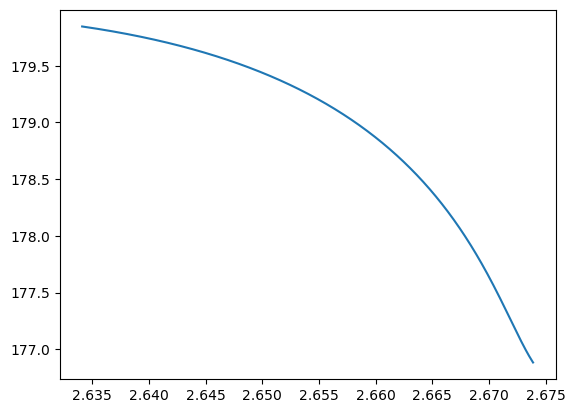

In [109]:
timestep = []
ir = []

for step in radialshock:
    ir.append(step[1])
    timestep.append(step[0])

fig,ax = plt.subplots()
ax.plot(timestep,ir)
plt.show()

# Phase 3: Radial reflected shock phase

When the inward radial shock hits the axis, $\kappa_{s} = 0 $. Thus in the computation when $\kappa_{s} <= 1$ the computation is stopped.

## Equations used for integration

### *Reflected Shock Speed*
$ \frac{dr_{r}}{dt} = - 0.3(\frac{dr_{s}}{dt})_{on_axis} $  (34)

### *Piston Speed*
$ \frac{dr_{p}}{dt} = \frac{-\frac{r_{p}}{\gamma I}(1- \frac{r_{s}^2}{r_{p}^2})\frac{dI}{dt} - \frac{r_{p}}{z_{f}}(1- \frac{r_{s}^2}{r_{p}^2})\frac{dz_{f}}{dt}}{\frac{\gamma - 1 }{\gamma} + \frac{1}{\gamma}\frac{r_{s}^2}{r_{p}^2}} $ (35)  

### *Elongation Speed*
$ \frac{dz_{f}}{dt} = -(\frac{2}{\gamma + 1})(\frac{dr_{s}}{dt})_{on-axis} $ (36)  

### *Circuit Equation*  
$ \frac{dI}{dt} = \frac{V_{0} - \frac{\int \iota t}{C_{0}} - r_{0}I - f_{c}\frac{\mu}{2\pi}(ln\frac{b}{r_{p}})I\frac{dz_{f}}{dt} + f_{c}\frac{\mu}{2\pi}\frac{z_{f}}{r_{p}}I\frac{dr_{p}}{dt}}{L_{0} + f_{c}\frac{\mu}{2\pi}(ln\frac{b}{r_{p}})z_{f}} $ (37)  

### *Tube Voltage will reuse the equation defined for phase 2*  

## Initial Conditions

Speed of Radial Shock is fixed at 0.3 of on-axis inward radial shock speed


In [77]:
#Reflected Shock Phase is computed in SI units.
#Convert initial values of RS Phase into SI units

radialreflectmap['TR'] = 0
radialreflectmap['IR'] = 1
radialreflectmap['VR'] = 2
radialreflectmap['plasma_I'] = 3
#Piston Position
radialreflectmap['KPR'] = 4
#Structure length
radialreflectmap['ZFR'] = 5
#Piston velocity
radialreflectmap['SPR'] = 6
#Velocity of elongation
radialreflectmap['SZR'] = 7
#RS Speed
radialreflectmap['RRFMM'] = 8
#plasma L
radialreflectmap['plasma_L'] = 9
#inductive eneregy
radialreflectmap['inductive_energy'] = 10
# 100 * EINP / (0.5 * C0 * V0 * V0)
radialreflectmap['0.5Ldot_work'] = 11
# ni / (10 ^ 23)
radialreflectmap['Ni'] = 12
# TMmax / (10 ^ 6)
radialreflectmap['T'] = 13
#-PLN, Ysxr
radialreflectmap['-PLN'] = 14
#NiMax
radialreflectmap['nimax'] = 15
#Tmax
radialreflectmap['Tpeak'] = 16
#100 * Wpiston / (0.5 * C0 * V0 * V0)
radialreflectmap['piston_work'] = 17
# thisis b
radialreflectmap['TRRadial'] = 18
# Peak velocity
radialreflectmap['TRMS'] = 19
#T axial end
radialreflectmap['gamma'] = 20
# z eff
radialreflectmap['z'] = 21
# EINP in joules
radialreflectmap['EINP'] = 22
#if no taper...
if TAPER ==0:
    VS = VS * RADA / T0
    RS = KS * RADA
    rp = KP * RADA
    ZF = ZF * RADA
    VZ = VZ * RADA / T0
    VP = VP * RADA / T0
else:
     VS = VS * ENDRAD / T0
     RS = KS * ENDRAD
     rp = KP * ENDRAD
     ZF = ZF * ENDRAD
     VZ = VZ * ENDRAD / T0
     VP = VP * ENDRAD / T0

T = T * T0
d = d * T0
I = I * I0
CH = IO * I0 * T0
IDOT = II * I0 / T0

# VRF is reflected shock speed taken as a constant value at 0.3 of on-axis forward shock speed
# Take strong planar shock approximation (Ref: Robert Gross: The Physics of Strong Shock Waves in Gases 1969, manuscript for Procs of International School of Physics "Enrico Fermi" Course XLVIII, High Energy Density, Varenna, Italy; Academic Press.)
# However we take RS speed as 0.3 of incident shock speed instead of 0.5 [for planar strong shock]as in R Gross; in order to account for diverging radial geometry
gratio = (gamma + 1) / (gamma - 1)

Pratio = 2 + gratio
Tratio = Pratio * ((gratio + Pratio) / (1 + gratio * Pratio))
Dratio = Pratio / Tratio
TMRS = TM * Tratio
TMmax = TMRS
TeV = TMRS / (1.16 * pow(10, 4))
# recalc g and z values.
gamma, z = CalcGZ(ZN,TM, zFLAG, gFLAG)
G1 = 2 / (gamma + 1)
G2 = (gamma - 1) / gamma

RRF = 0
FRF = 0.33
VSV = VS

VRF = -FRF * VS
MUP = MU / (2 * Pi)
VZ = -G1 * VS

#Introduce differential in current factors for axial and radial phases; already introduced earlier around 815
#CURRF = CURRF * CFR

while True:
    T = T + d

    RRF = RRF + VRF * d
    VRFCMUS = VRF * pow(10, -4)

    K1 = 0
    E1 = G1 * K1 * VSV
    E2 = (1 / gamma) * (rp / I) * (1 - K1 * K1) * IDOT
    E3 = (G1 / 2) * (rp / ZF) * (1 - K1 * K1) * VZ
    E4 = G2 + (1 / gamma) * K1 * K1

    VP = (E1 - E2 - E3) / E4
    IDOT = (V0 - (CH / C0) - I * R0 - I * CURRF * MUP * ((numpy.log(RADB / rp)) * VZ - (ZF / rp) * VP)) / (L0 + MUP * CURRF * ((numpy.log(C)) * Z0 * tc5 + (numpy.log(RADB / rp)) * ZF))

    V = MUP * I * ((numpy.log(RADB / rp)) * VZ - (ZF / rp) * VP) + MUP * ((numpy.log(RADB / rp)) * ZF + (numpy.log(C)) * Z0 * tc5) * IDOT
    V = V * CURRF

    I = I + IDOT * d
    CH = CH + I * d
    rp = rp + VP * d
    ZF = ZF + VZ * d

# D is time increment in secs, DKPR is piston position increment & DZFR length position increment, both in SI units

    DKPR = SPR * d * pow(10, 4)
    DZFR = SZR * d * pow(10, 4)
    if IR > Ipeak: 
        Ipeak = IR

#Obtain Max induced voltage
    if VR > VRMAX: 
        VRMAX = VR

    TRRadial = TR * pow(10, 3) - trradialstart * pow(10, 9)

    if SSR < peakvs: 
        peakvs = SSR

    if SPR < peakvp: 
        peakvp = SPR

#Convert to Real convenient units for print out
    TR = T * pow(10, 6)
    VR = V * pow(10, -3)
    R = I * pow(10, -3)
    kpr = rp * pow(10, 3)
    zfr = ZF * pow(10, 3)
    SPR = VP * pow(10, -4)
    SZR = VZ * pow(10, -4)
    IDOTKAUS = IDOT * pow(10, -9)
    RRFMM = RRF * pow(10, 3)

    TRRadial = TR * pow(10, 3) - trradialstart * pow(10, 9)
    #Integrate to find EINP, energy dissipated by dynamic resistance effect, which is 0.5 (Ldot) I^2, considering current taking part in the motion
    EINP = EINP + pow(10, -7) * (SZR * pow(10, 4) * numpy.log(1000 * RADB / kpr) - (SPR * pow(10, 4) * (1000 / kpr) * (zfr / 1000))) * IR * IR * pow(10, 6) * CURRF * CURRF * d
    # Also integrate for piston work
    Wpiston = Wpiston + 0.1 * (DZFR * numpy.log(1000 * RADB / kpr) - DKPR * (zfr / kpr)) * IR * IR * CURRF * CURRF
    if IR > Ipeak: 
        Ipeak = IR
    #Determine max induced voltage for beam-gas neutron yield computation
    if VR > VRMAX: 
        VRMAX = VR
    Lplasma = Laxial + (zfr * 2 * pow(10, -1) * numpy.log(1000 * RADB / kpr))
    Einductance = 0.5 * pow(10, 6) * IR * IR * (CURRF * CURRF * Lplasma * pow(10, -9) + L0)
    #use Dratio from RS of strong shocks as described above
    ni = ni1 * Dratio
    nimax = nimax1 * Dratio

    step = []
    step.append(TR)
    step.append(IR)
    step.append(VR)
    step.append(IR * CURRF)
    step.append(kpr)
    step.append(zfr)
    step.append(SPR)
    step.append(SZR)
    step.append(RRFMM)
    step.append(Lplasma)
    step.append(100 * Einductance / (0.5 * C0 * V0 * V0))
    step.append(100 * EINP / (0.5 * C0 * V0 * V0))
    step.append(ni / pow(10, 23))
    step.append(TMRS / pow(10, 6))
    step.append(-PLN)
    step.append(nimax / pow(10, 23))
    step.append(TMmax / pow(10, 6))
    step.append(100 * Wpiston / (0.5 * C0 * V0 * V0))
    step.append(TRRadial)
    step.append(TMRS)
    step.append(gamma)
    step.append(z)
    step.append(EINP)
    radialreflect.append(step)

    if RRF > rp:
        break

#RS HAS HIT PISTON. RS PHASE ENDS        


# Phase 4: Slow Compression and Pinch
Radiative Phase is integrated in real quantities  
  
As RS hits piston, the pressure exerted by the doubly shocked column on the piston shoots up by a factor of Pratio; this will slow the piston down further or even push it back. Thie effect is included in the following section.  
However, in reality, due to 2-D effect, the over-pressure may not be significant.  

## Equations used for integration

### *Piston Speed*

$ \frac{dr_{p}}{dt} = \frac{\frac{-r_{p}}{\gamma I}\frac{dI}{dt} - \frac{1}{\gamma + 1}\frac{r_{p}}{z_{f}}\frac{dz_{f}}{dt} + \frac{4\pi(\gamma -1)}{\mu\gamma z_{f}}\frac{r_{p}}{f_{c}^2I^2}\frac{dQ}{dt}}{\frac{\gamma -1}{\gamma}} $  (38)   

Modelling for piston speed now considers power change. Specific heat ratio $\gamma$ and the charge number $Z$ is computed using the corona model implemented as *CalcGZ* Values depend on plasma species.  
    
### *Column Elongation*

$\frac{dz_{f}}{dt} = [\frac{\mu}{4\pi^2(\gamma+1)\rho_{0}}]^\frac{1}{2}\frac{If_{c}}{r_{p}}$ (51)  

Unlike phase 3 where the speed is fixed to a factor of 0.3, the elongation speed in phase 4 can be driven fully by pressure from plasma  

### *Circuit Current Equation*

$\frac{dI}{dt} = \frac{V_{0} - \frac{\int Ift}{C_{0}} - \frac{\mu}{2\pi}(ln\frac{b}{r_{p}})\frac{dz_{f}}{dt}If_{c} + \frac{\mu}{2\pi}\frac{z_{f}}{r_{p}}If_{c} - I(Rf_{c} + r_{0})}{L_{0} + \frac{\mu}{2\pi}f_{c}((lnc)z_{0} + (ln\frac{b}{r_{p}})z_{f})} $ (52)  

### *Joule Term*

$\frac{dQ_{J}}{dt} = RI^2f_{c}^2 $ (39)  

### *Plasma Resistance as Spitzer form*

$ R = \frac{1290Zz_{f}}{\pi r_{p}^2T^\frac{3}{2}} $ (40)  

### *Bennett form temperature*

$ T = \frac{\mu}{8\pi^2k}I^2\frac{f_{c}^2}{DN_{0}a^2f_{mr}} $ (41)  

### *Bremsstrahlung loss term*

$ \frac{dQ_{B}}{dt} = -1.6 x 10^{-40}N_{i}^2(\pi r_{p}^2)z_{f}T^\frac{1}{2}Z^3 $ (42)  

$ N_{0} = 6 x 10^26\frac{\rho_{0}}{M} $ ; $ N_{i} = N_{a}f_{mr}(\frac{a}{r_{p}})^2 $ (43) 

$ Z_{n} $ is atomic number, $ N_{0} $ is ambient number density, $ N_{i} $ is ion number density

### *Line loss*

$ \frac{dQ_{L}}{dt} = -4.6 x 10^{-31}N_{i}^2ZZ_{n}^4(\pi r_{p}^2)\frac{z_{f}}{T} $ (44)  

### *Total power gain or loss by plasma Column*

$ \frac{dQ}{dt} = \frac{dQ_{J}}{dt} + \frac{dQ_{B}}{dt} + \frac{dQ_{L}}{dt} $ (45)  

### *Plasma Self Absorption: photonic excitation number*
$ M = \frac{1.66 x 10^-15 r_p Z^0.5_n n_i}{Z T^1.5} $ (46)    

$T$ is in $eV$

### *Plasma Self Absorption: Self absorption correction factor*
$ A_1 = (fract{(1+10^-14 n_i Z)}{T^3.5}; A_2 = \frac{1}{A_1}; A = A^{(1+M)}_2 $ (47)  

### *Plasma Self Absorption: When correction factor goes from 1 to $\frac{1}{e} $, emission becomes:*
$ \frac{dQ_L}{dt} = -constZ^{0.5}Z^{3.5}_nr_pz_fT^4 $ (48)  

$const$ is $ 4.62 x 10^{-16} $ 

### *Soft X-Rays of gases calcuated using equation (44)*

### *Neutron yield : Thermal nuclear term*

$dYth = 0.5n^2_i\pi r^2_pz_f<\sigma v>$ , where $<\sigma v>$ is the fusion corss section and velocity product,given plasma temperature  (49)  

### *Neutron yield: beam target term*

$Y_{b-t} = \frac{C_nn_iI^2_pinchz^2_p(ln\frac{b}{r+p})\sigma}{V^{\frac{1}{2}}_{max}} $ (50)  



In [78]:
FLAG = 0
NBN = 0
NTN = 0
NN = 0
PLN = 0
QJ = 0
QBR = 0
QLN = 0
sflag1 = 0
sflag2 = 0
sflag3 = 0
RPSTART = rp
TeVSTART = TeV
rbr = 0
SDSPEEDSTART = pow(((gamma * dissociatenumber * (1 + z) * bc * TM / (MW * mi))), 0.5)
TRAD1 = 0.5 * RPSTART / SDSPEEDSTART
TRAD1 = 2 * TRAD1
d = DREAL / pow(10, 8)
TStart = T
Ipinch = I * CURRF / 1000

amin = kpr
zmax = 0
Tpinch = 0
nipinch = 0
Tpinchmin = pow(10, 9)
QREC = 0
Q = 0
QRAD = 0
rbr = 0
rln = 0
rrec = 0
rsxr = 0
#pre-init ENDFLAG to default 0
ENDFLAG = 0
sfactor = 0
print(rp)
# Select Table for G & Z; according to which gas is used, We assume Helium (ZN == 1)
while True:
    
    gamma, z =  CalcGZLog(ZN, TM, zFLAG, gFLAG)  
    G1 = 2 / (gamma + 1)
    G2 = (gamma - 1) / gamma

# Compute Joule heating and radiation terms
#assume no taper
    if TAPER == 0:
        ni = N0 * fe * massfr * (RADA / rp) * (RADA / rp)
        # DNchange (original code is wrong, this overwrites TM even if there is taper)
        TM = MUK * I * I * CURRF * CURRF / ((1 + z) * N0 * RADA * RADA * fe * massfr)
    else:
        ni = N0 * fe * massfr * (ENDRAD / rp) * (RADA / rp)
        # DNchange
        TM = MUK * I * I * CURRF * CURRF / ((1 + z) * N0 * ENDRAD * ENDRAD * fe * massfr)
    
   
    TeV = TM / (1.16 * pow(10, 4))
    R = 1290 * z * ZF / (Pi * rp * rp * pow(TM, 1.5))
    PJ = R * I * I * CURRF * CURRF
    PBR = -(CON11 * ni) * pow(TM, 0.5) * (CON12 * ni) * Pi * (rp * rp) * ZF * pow(z, 3)    
    PREC = -5.92 * pow(10, -35) * ni * ni * pow(z, 5) * Pi * (rp * rp) * ZF / pow(TM, 0.5)
    PLN = -(CON2 * ni) * ni * z * pow(ZN, 4) * Pi * (rp * rp) * ZF / TM

    # Apply Plasma Self Absorption correction to PBR PREC and PLN:
    # PM is photonic excitation number; AB is absorption corrected factor
    # If AB<1/2.7183, Radiation goes from volume-like PRAD to surface-like PRADS; PRADS has a limit being Blackbody Rad PBB
    # We consider only volume (absorption corrected) radiation for PBR PREC and PLINE and PSXR; not including any contribution from surface radiation.

    PM = 1.66 * pow(10, -11) * (rp * 100) * pow(ZN, 0.5) * (ni * pow(10, -6)) / (z * pow(TeV, 1.5))
    AB = 1 + ((pow(10, -14) * (ni * pow(10, -6)) * z) / pow(TeV, 3.5))
    AB = 1 / AB
    AB = pow(AB, (1 + PM))
    PRADS = -2.3 * pow(10, -15) * pow(ZN, 3.5) * pow(z, 0.5) * pow(TM, 4) * 3.142 * rp * (2 * ZF)
    # calibration factor for neon (NX2); got to check for other machines and gases that at cross-over point from volume to surface emission there is a smooth transition in power.
    PRADS = 0.032 * PRADS
    PBB = -5.7 * pow(10, -8) * pow(TM, 4) * (3.142 * rp * (2 * ZF + rp))

#For now, just handling Helium ZN = 1, MW=4
# For deuterium, compute 1. thermonuclear neutron yield component: SIGV computed in m3sec-1

    #print(MW)
    #print(TeV)
    if TeV <= 100: #Then GoTo 4623
        SIGV = 0
    else:   
        if TeV > pow(10, 4): #Then GoTo 4624
            SIGV = 2.4 * pow(10, -26) * pow((TeV / 1000), 1.55)
        if TeV > pow(10, 3): #Then GoTo 4625
            SIGV = 2 * pow(10, -28) * pow((TeV / 1000), 3.63)
        if TeV > 500: #Then GoTo 4626
            SIGV = 2 * pow(10, -28) * pow((TeV / 1000), 7.7)
        if TeV > 100: #Then GoTo 4627
            SIGV = pow(10, -27) * pow((TeV / 1000), 10)

    SIGV = pow(10, -27) * pow((TeV / 1000), 10)
    NTNDOT = 0.5 * ni * ni * 3.142 * (rp * rp) * ZF * SIGV
    NTN = NTN + NTNDOT * d
    # Calculate rate of net power emission, absorption-corrected
    PRAD = (PBR + PLN + PREC) * AB
    radiativemap['PRADVOL'] = 0
    step = [PRAD]
    if sflag1 != 1: #Then GoTo 4720
        sflag1 = 1
        if AB <= (1 / 2.7183):
            sfactor = 1
            sflag2 = 1
            PRADS = sfactor * PRADS
            PRAD = PRADS
            if -PRAD > -PBB: 
                PRAD = PBB
    else:        
        if sflag2 != 1 and sflag3 != 1: #Then GoTo 4740   
            if AB <= 1 / 2.7183: #Then GoTo 4750
                sfactor = PRAD / PRADS
                sflag3 = 1
            PRADS = sfactor * PRADS
            PRAD = PRADS
            if -PRAD > -PBB: 
                PRAD = PBB
          
    QDOT = PJ + PRAD

# Compute slow piston speed

    E2 = (1 / gamma) * (rp / I) * IDOT
    E3 = (1 / (gamma + 1)) * (rp / ZF) * VZ
    # E5 term in VP (related to dQ/dt) not corrected.

    correctfactor = (1 + z) * ni * bc
    correctfactor = 1
    E5 = (4 * Pi * (gamma - 1) / (MU * gamma * ZF)) * ((rp * correctfactor) / (I * I * CURRF * CURRF)) * QDOT
    E4 = (gamma - 1) / gamma
    VP = (-E2 - E3 + E5) / E4

    IDOT1 = V0 - CH / C0
    IDOT2 = -MUP * (numpy.log(RADB / rp)) * VZ * I * CURRF
    IDOT3 = MUP * I * ZF * VP * CURRF / rp
    IDOT4 = -I * (R * CURRF + R0)

    #Taper = 0
    if TAPER == 0:
        IDOT5 = L0 + MUP * (numpy.log(C)) * Z0 * CURRF + MUP * (numpy.log(RADB / rp)) * ZF * CURRF
    else:
        IDOT5 = L0 + MUP * (numpy.log(C)) * Z0 * CURRF * tc5 + MUP * (numpy.log(RADB / rp)) * ZF * CURRF
    IDOT = (IDOT1 + IDOT2 + IDOT3 + IDOT4) / IDOT5
    ZFDOT = pow(((MU * (gamma + 1)) / (16 * Pi * Pi * RHO)), 0.5) * I * CURRF / rp
    #taper = 0
    if TAPER == 0:
        V = MUP * I * ((numpy.log(RADB / rp)) * VZ - (ZF / rp) * VP) + MUP * (((numpy.log(RADB / rp)) * ZF) + numpy.log(C) * Z0) * IDOT + R * I
    else:
        V = MUP * I * ((numpy.log(RADB / rp)) * VZ - (ZF / rp) * VP) + MUP * (((numpy.log(RADB / rp)) * ZF) + numpy.log(C) * Z0 * tc5) * IDOT + R * I
    
    V = V * CURRF
    T = T + d
    I = I + IDOT * d
    CH = CH + I * d
    rpOLD = rp
    rp = rp + VP * d
    SPR = -VP * pow(10, -4)
    # Set Variable time increment to suit both slow and fast piston
    if SPR < pow(10, 2): 
        d = DREAL / 5
    if SPR == pow(10, 2):
        d = DREAL / 10
    if SPR > pow(10, 2): 
        d = DREAL / 100
    if SPR > pow(10, 3): 
        d = DREAL / pow(10, 4)
    if SPR > pow(10, 4): 
        d = DREAL / pow(10, 5)
    if SPR > pow(10, 5): 
        d = DREAL / pow(10, 6)

    if SPR > pow(10, 6): 
        d = DREAL / pow(10, 7)
    if SPR > pow(10, 7): 
        d = DREAL / pow(10, 8)
    if SPR > pow(10, 8): 
        d = DREAL / pow(10, 9)

    #Set limit for piston position
        #DNchange
        #Taper = 0
    if TAPER == 0:    
        if rp < math.exp(-8) * RADA:         
            print("Slow compression phase stopped either on preset time or on RP limit")
            ENDFLAG = 1
            break
    else:
        if rp < math.exp(-7) * ENDRAD:
            print("Slow compression phase stopped either on preset time or on RP limit")
            ENDFLAG = 1
            break
    
    ZF = ZF + ZFDOT * d
    # uncorrected for absorption
    QJ = QJ + PJ * d
    QBR = QBR + PBR * d
    QLN1 = QLN
    QLN = QLN + PLN * d
    # for N2 find line radiation within temp range 0.86-2x10^6K; and put as SXR yield
    #for Neon find line radiation within temp range 2.3-5x10^6K; and put as SXR yield
    radiativemap['-QLN'] = 1
    step.append(-QLN)
    #just ZN = 1
    #if TM >= 0.86 * pow(10, 6):
    #uncorrected for absorption
    QSXR = QLN1 + PLN * d
    QREC = QREC + PREC * d
    #Corrected for absorption
    Q = Q + QDOT * d
    QRAD = (QRAD + PRAD * d)
    #estimate proportion of each radiation component using their unabsorbed values:  hence estimate absorption corrected QBR, QLN, QREC; including contribution from surface radiation
    #uncorrected for absorption
    QTOTAL = (QBR + QLN + QREC)
    if -QTOTAL >= math.exp(-6):
        rbr = QBR / QTOTAL
        rln = QLN / QTOTAL
        rrec = QREC / QTOTAL
        rsxr = QSXR / QTOTAL
        # corrected for absorption
        QBR = rbr * QRAD
        QLN = rln * QRAD
        QREC = rrec * QRAD
        #not adjusting for nirtrogen and neon. May have a small error
        if TM >= 0.86 * pow(10, 6) and TM < 2.3 * pow(10, 6):
            QSXR = rsxr * QRAD
    TR = T * pow(10, 6)
    TR = T * pow(10, 6)
    VR = V * pow(10, -3)
    IR = I * pow(10, -3)
    kpr = rp * pow(10, 3)
    zfr = ZF * pow(10, 3)
    SPR = VP * pow(10, -4)
    SZR = ZFDOT * pow(10, -4)
    IDOTKAUS = IDOT * pow(10, -9)
    TMB = TM
    TRRadial = TR * pow(10, 3) - trradialstart * pow(10, 9)
    
    if IR > Ipeak: 
        Ipeak = IR
    #Determine max induced voltage for beam-gas neutron yield computation
    if VR > VRMAX: 
        VRMAX = VR
    if kpr < amin: 
        amin = kpr
    if zfr > zmax: 
        zmax = zfr
    if TM > Tpinch:
        Tpinch = TM
    if ni > nipinch:
        nipinch = ni
    if TM < Tpinchmin: 
        Tpinchmin = TM
    # D is time increment in secs, DKPR is piston position increment & DZFR length position increment, both in SI units
    DKPR = SPR * d * pow(10, 4)
    DZFR = SZR * d * pow(10, 4)

    #Integrate to find EINP, energy dissipated by dynamic resistance effect, which is 0.5 (Ldot) I^2, considering current taking part in the motion
    EINP = EINP + pow(10, -7) * (SZR * pow(10, 4) * numpy.log(1000 * RADB / kpr) - (SPR * pow(10, 4) * (1000 / kpr) * (zfr / 1000))) * IR * IR * pow(10, 6) * CURRF * CURRF * d
    # Also integrate for piston work
    Wpiston = Wpiston + 0.1 * (DZFR * numpy.log(1000 * RADB / kpr) - DKPR * (zfr / kpr)) * IR * IR * CURRF * CURRF
    Lplasma = Laxial + (zfr * 2 * pow(10, -1) * numpy.log(1000 * RADB / kpr))
    Einductance = 0.5 * pow(10, 6) * IR * IR * (CURRF * CURRF * Lplasma * pow(10, -9) + L0)
    
    #ActiveSheet.Cells(rowj, 1) = TR
    radiativemap['TR'] = 1
    step.append(TR)
    #ActiveSheet.Cells(rowj, 2) = IR
    radiativemap['IR'] = 2
    step.append(IR)
    #ActiveSheet.Cells(rowj, 3) = VR
    radiativemap['VR'] = 3
    step.append(VR)
    #ActiveSheet.Cells(rowj, 52) = TR
    #ActiveSheet.Cells(rowj, 53) = IR * CURRF
    radiativemap['plasma_I'] = 4
    step.append(IR * CURRF)
    #ActiveSheet.Cells(rowj, 55) = kpr, piston_position
    radiativemap['KPR'] = 5
    step.append(kpr)
    #ActiveSheet.Cells(rowj, 56) = zfr, Structure length 
    radiativemap['ZFR'] = 6
    step.append(zfr)
    #ActiveSheet.Cells(rowj, 58) = SPR, piston velocity
    radiativemap['SPR'] = 7
    step.append(SPR)
    #ActiveSheet.Cells(rowj, 59) = SZR, velocity of elongation
    radiativemap['SZR'] = 8
    step.append(SZR)
    #ActiveSheet.Cells(rowj, 61) = Lplasma
    radiativemap['plasma_L'] = 9
    step.append(Lplasma)
    #ActiveSheet.Cells(rowj, 62) = 100 * Einductance / (0.5 * C0 * V0 * V0), inductive energy
    radiativemap['inductive_energy'] = 10
    step.append(100 * Einductance / (0.5 * C0 * V0 * V0))
    #ActiveSheet.Cells(rowj, 63) = 100 * EINP / (0.5 * C0 * V0 * V0)
    radiativemap['0.5Ldot_work'] = 11
    step.append(100 * EINP / (0.5 * C0 * V0 * V0))
    #ActiveSheet.Cells(rowj, 64) = ni / (10 ^ 23)
    radiativemap['Ni'] = 12
    step.append(ni / pow(10, 23))
    #ActiveSheet.Cells(rowj, 65) = TM / (10 ^ 6)
    radiativemap['T'] = 13
    step.append(TM / pow(10, 6))
    #ActiveSheet.Cells(rowj, 66) = -PLN / (10 ^ 9) , YSXR
    radiativemap['-PLN'] = 14
    step.append(-PLN / pow(10, 9))
    #ActiveSheet.Cells(rowj, 68) = TMmax / (10 ^ 6)
    radiativemap['Tpeak'] = 15
    step.append(TMmax / pow(10, 6))
    #ActiveSheet.Cells(rowj, 67) = nimax / (10 ^ 23)
    radiativemap['nimax'] = 16
    step.append(nimax / pow(10, 23))
    #ActiveSheet.Cells(rowj, 69) = 100 * Wpiston / (0.5 * C0 * V0 * V0)
    radiativemap['piston_work'] = 17
    step.append(100 * Wpiston / (0.5 * C0 * V0 * V0))
    #ActiveSheet.Cells(rowi, 6) = TR
    #ActiveSheet.Cells(rowi, 7) = TRRadial
    radiativemap['TRRadial'] = 18
    step.append(TRRadial)
    #ActiveSheet.Cells(rowi, 8) = IR
    #ActiveSheet.Cells(rowi, 9) = VR
    #ActiveSheet.Cells(rowi, 11) = kpr
    #ActiveSheet.Cells(rowi, 12) = zfr
    #ActiveSheet.Cells(rowi, 14) = SPR
    #ActiveSheet.Cells(rowi, 15) = SZR

    #ActiveSheet.Cells(rowi, 17) = TM
    #ActiveSheet.Cells(rowi, 18) = PJ, peak velocity for plasma
    radiativemap['PJ'] = 19
    step.append(PJ)
    #ActiveSheet.Cells(rowi, 19) = PBR
    radiativemap['PBR'] = 20
    step.append(PBR)
    #ActiveSheet.Cells(rowi, 20) = PREC
    radiativemap['PREC'] = 21
    step.append(PREC)
    #ActiveSheet.Cells(rowi, 21) = PLN
    radiativemap['PLN'] = 22
    step.append(PLN)
    #ActiveSheet.Cells(rowi, 22) = PRAD
    radiativemap['PRAD']  = 23
    step.append(PRAD)
    #ActiveSheet.Cells(rowi, 23) = QDOT
    radiativemap['QDOT'] = 24
    step.append(QDOT)
    #ActiveSheet.Cells(rowi, 24) = QJ
    radiativemap['QJ'] = 25
    step.append(QJ)
    #ActiveSheet.Cells(rowi, 25) = QBR
    radiativemap['QBR'] = 26
    step.append(QBR)
    #ActiveSheet.Cells(rowi, 26) = QREC
    radiativemap['QREC'] = 27
    step.append(QREC)
    #ActiveSheet.Cells(rowi, 27) = QLN
    radiativemap['QLN'] = 28
    step.append(QLN)
    #ActiveSheet.Cells(rowi, 28) = QRAD
    radiativemap['QRAD'] = 29
    step.append(QRAD)
    #ActiveSheet.Cells(rowi, 29) = Q
    radiativemap['Q'] = 30
    step.append(Q)
    #ActiveSheet.Cells(rowi, 30) = AB
    radiativemap['AB'] = 31
    step.append(AB)
    #ActiveSheet.Cells(rowi, 31) = PBB
    radiativemap['PBB'] = 32
    step.append(PBB)
    #ActiveSheet.Cells(rowi, 32) = g
    radiativemap['gamma'] = 33
    step.append(gamma)
    #ActiveSheet.Cells(rowi, 33) = z
    radiativemap['z'] = 34
    step.append(z)
    #ActiveSheet.Cells(rowi, 34) = NTN
    radiativemap['NTN'] = 35
    step.append(NTN)
    #ActiveSheet.Cells(rowi, 35) = NBN
    radiativemap['NBN'] = 36
    step.append(NBN)
    #ActiveSheet.Cells(rowi, 36) = NN
    radiativemap['NN'] = 37
    step.append(NN)
    #ActiveSheet.Cells(rowi, 37) = ni
    #ActiveSheet.Cells(rowi, 39) = PRADS
    radiativemap['PRADS'] = 38
    step.append(NN)
    #ActiveSheet.Cells(rowi, 40) = AB
    radiativemap['AB'] = 39
    step.append(AB)
    #ActiveSheet.Cells(rowi, 41) = EINP
    radiativemap['EINP'] = 40
    step.append(EINP)
    #ActiveSheet.Cells(rowi, 42) = QSXR
    radiativemap['QSXR'] = 41
    step.append(QSXR)
    #ActiveSheet.Cells(rowi, 45) = rbr
    radiativemap['rbr'] = 42
    step.append(rbr)
    #ActiveSheet.Cells(rowi, 47) = rln
    radiativemap['rln'] = 43
    step.append(rln)
    #ActiveSheet.Cells(rowi, 46) = rrec
    radiativemap['rrec'] = 44
    step.append(rrec)
    #ActiveSheet.Cells(rowi, 48) = rsxr
    radiativemap['rsxr'] = 45
    step.append(rsxr)
    #ActiveSheet.Cells(rowi, 51) = QTOTAL
    radiativemap['QTOTAL'] = 46
    step.append(QTOTAL)
    radiative.append(step)
    # Set limit for duration of radiative phase (1 ns for every mm radius)
    # TRAD = 1000 * RADA * 10 ^ -9
    # TRAD2 = (16 * (10 ^ -7)) * (RPSTART * 100) / (TeVSTART ^ 0.5)
    # Set limit for duration of radiative phase using transit time of small disturbance across pinch radius
    TRAD = TRAD1
    if T > (TStart + TRAD):
        print('slow compression phase stopped either on preset time or on RP limit')
        ENDFLAG = 2
        break
#Slow Compression Complete

0.0015216747323282067
slow compression phase stopped either on preset time or on RP limit


## Phase 5: Plasma expansion and collapse

### *Normalised circuit current*  

$\frac{d\iota}{d\tau} = \frac{1 - \int\iota d\tau - \beta\iota\frac{d\zeta}{d\tau}e  - \delta\iota}{1+\beta+\beta(\zeta - 1)e}$  (54)  

$e = \frac{(lnc + \frac{1}{2})}{ln c}$  

$\iota$,$\int\iota d\tau$ are initialized to the last step $\iota$ and $\int\iota d\tau$ values from phase 4. 

### *Normaised Plasma motion*

$\frac{d^2\zeta}{d\tau^2} = \frac{\alpha^2\iota^2e_1 - h^2(\frac{d\zeta}{d\tau})^2}{1 + h^2(\zeta - 1)} $   (55)   

$\zeta$ is initialized to $1+\zeta_f$, where $\zeta_f$ is the last length of the plasma focus column. Although that $\zeta_f$ is normalized to $z_o$ instead of a  



In [79]:
#print(rp)
#ActiveSheet.Cells(7, 14) = -QLN
pinch['-QLN'] = -QLN
EINP1 = EINP
#Slow compression Phase Stopped: Time limit or RP limit.
#ActiveSheet.Cells(7, 15) = ENDFLAG
pinch['ENDFLAG'] = ENDFLAG
TSlowcompressionphase = (T - TStart) * pow(10, 9)
#ActiveSheet.Cells(11, 12) = TSlowcompressionphase
pinch['pinchduration'] = TSlowcompressionphase
#ActiveSheet.Cells(11, 10) = (TRRadial * 10 ^ -3)
pinch['TRRadial'] = TRRadial * pow(10,-3)
#ActiveSheet.Cells(11, 14) = (TRRadial * 10 ^ -3) + trradialstart * (10 ^ 6)
pinch['tradialend'] = (TRRadial * pow(10, -3)) + trradialstart * pow(10, 6)
# Calculate energy in inductances

Ecap = 0.5 * C0 * V0 * V0
EL0 = 0.5 * L0 * I * I
ELt = 0.5 * (MU / (2 * Pi)) * (numpy.log(C)) * Z0 * I * I * CURRF * CURRF
ELp = 0.5 * (MU / (2 * Pi)) * (numpy.log(RADB / rp)) * ZF * I * I * CURRF * CURRF
MAG = MU * I * CURRF / (2 * Pi * rp)
EMAGp = (MAG * MAG / (2 * MU)) * Pi * rp * rp * ZF
EL0 = (EL0 / Ecap) * 100
ELt = (ELt / Ecap) * 100
#ELp = (ELp / Ecap) * 100
#EMAGp = (EMAGp / Ecap) * 100
SFI0 = (I0 * pow(10, -3)) / (RADA * 100) / (numpy.sqrt(P0))
SFIpeak = (Ipeak) / (RADA * 100) / (numpy.sqrt(P0))
SFIdip = (IR) / (RADA * 100) / (numpy.sqrt(P0))
#taper = 0
if TAPER == 0:
    Kmin = kpr / (RADA * 1000)
else:
    Kmin = kpr / (ENDRAD * 1000)
    
ID = (Ipeak) / (RADA * 100)
Ec = 0.5 * C0 * (V0 - (CH / C0)) * (V0 - (CH / C0))
Ec = (Ec / Ecap) * 100
if rp > 0:
    ELp = 0.5 * (MU / (2 * Pi)) * (numpy.log(RADB / rp)) * ZF * I * I * CURRF * CURRF
    ELp = (ELp / Ecap) * 100
    #EMAGp = (MAG * MAG / (2 * MU)) * Pi * rp * rp * ZF
    EMAGp = (EMAGp / Ecap) * 100
    MAG = MU * I * CURRF / (2 * Pi * rp)
    EMAGp = (MAG * MAG / (2 * MU)) * Pi * rp * rp * ZF
else:
    print('Check parameters, numeric errors in phase 5')
    raise ValueError("Check invalid rp")

EINP = (EINP / Ecap) * 100
# Calculate loss of energy from inductances during current dip; ignoring capacitative energy change
L0t = L0 + (MU / (2 * Pi)) * (numpy.log(C)) * Z0
Excircuit = 100 - (EL0 + ELt + ELp + EMAGp + Ec)
Lp = (MU / (2 * Pi)) * (numpy.log(RADB / rp)) * ZF
Edip = 0.5 * L0t * CURRF * CURRF * (Ipeak * Ipeak * pow(10, 6) - I * I) - 0.5 * Lp * CURRF * CURRF * I * I
Edip = (Edip / Ecap) * 100

SFIpinch = (Ipinch) / (RADA * 100) / (numpy.sqrt(P0))

# Calculate  neutron yield in D2; 2 components viz 1. thermonuclear, 2. Beam-gas :

pinch['VRMAX'] = VRMAX

#ZN = 1, MW =4
# Computed VRMAX varies typically in range of 30-60kV for small to big devices; too low compared to expt observations;
# Multiplying by factor 2 will get the range closer to 50-100kV; the range generally observed to be reponsible for beam-target neutrons in PF
# Multiply VRMAX by factor to get closer to experimental observations; fine tuned to fit the optimum pressure for Yn for the UNU/ICTP PFF (around 3-3.5 torr at 15 kV)

VRMAX = VRMAX * 3
#Only MW = 4

# For deuterium, compute 2. Beam-gas neutron yield component (ref: NRL Formulary 2006 pg 43)
sig = (409 + (pow((pow((1.076 - 0.01368 * VRMAX), 2) + 1), -1)) * 50200) / (VRMAX * (math.exp(45.95 * pow(VRMAX, -0.5)) - 1))
sig = sig * pow(10, -28)

# Calibrate for UNU/ICTP PFF for max neutron yield at optimum pressure as 10^8
sig = sig * 6.34 * pow(10, 8)
# Change Calibration to NESSI-like, at expt point of 0.5MA pinch current
sig = sig / 23.23
# correct for dissociation number change in June 2016
# DNchange
sig = sig / dissociatenumber
# Use model Ni I^2 zf^2 LOG(b/rp) VRMAX^-0.5 sig
BN = ni * pow((Ipinch * 1000), 2) * pow(ZF, 2) * (math.exp(RADB / rp)) * pow(VRMAX, -0.5) * sig

NN = NBN + NTN
#ActiveSheet.Cells(7, 11) = NTN
pinch['NTN'] = NTN
#ActiveSheet.Cells(7, 12) = NBN
pinch['NBN'] = NBN
#ActiveSheet.Cells(7, 13) = NN
pinch['NN'] = NN
#ActiveSheet.Cells(17, 1) = Ecap / 1000
pinch['E0'] = Ecap / 1000
#ActiveSheet.Cells(17, 2) = RESF
pinch['RESF'] = RESF
#ActiveSheet.Cells(17, 3) = C
pinch['C'] = C
#ActiveSheet.Cells(17, 4) = L0 * 10 ^ 9
pinch['L0'] = L0 * pow(10, 9)
#ActiveSheet.Cells(17, 5) = C0 * 10 ^ 6
pinch['C0'] = C0 * pow(10, 6)
#ActiveSheet.Cells(17, 6) = R0 * 10 ^ 3
pinch['R0'] = R0 * pow(10, 3)
#ActiveSheet.Cells(17, 7) = RADB * 100. Length b
pinch['RADB'] = RADB * 100
#ActiveSheet.Cells(17, 8) = RADA * 100
pinch['RADA'] = RADA * 100
#ActiveSheet.Cells(17, 9) = Z0 * 100
pinch['Z0'] = Z0 * 100
#ActiveSheet.Cells(17, 10) = V0 / 1000
pinch['V0'] = V0 / 1000

#ActiveSheet.Cells(17, 11) = P0
pinch['P0'] = P0
#ActiveSheet.Cells(17, 12) = Ipeak
pinch['Ipeak'] = Ipeak
#ActiveSheet.Cells(17, 13) = Ipinch
pinch['Ipinch'] = Ipinch
#ActiveSheet.Cells(17, 14) = Tpinchmin / 10 ^ 6
pinch['Tpinchmin'] = Tpinchmin / pow(10, 6)
#ActiveSheet.Cells(17, 15) = Tpinch / 10 ^ 6
pinch['Tpinch'] = Tpinch / pow(10, 6)
#ActiveSheet.Cells(17, 16) = ZZR
pinch['ZZR'] = ZZR
#ActiveSheet.Cells(17, 17) = -peakvs
pinch['-peakvs'] = -peakvs
#ActiveSheet.Cells(17, 18) = -peakvp
pinch['-peakvp'] = -peakvp
#ActiveSheet.Cells(17, 19) = amin / 10
pinch['amin'] = amin / 10
#ActiveSheet.Cells(17, 20) = zmax / 10
pinch['zmax'] = zmax / 10
#ActiveSheet.Cells(17, 21) = TSlowcompressionphase
# ActiveSheet.Cells(17, 22) = VRMAX (before x3 for effective beam energy)
# ActiveSheet.Cells(17, 23) = nipinch / 10 ^ 23
pinch['nipinch'] = nipinch / pow(10, 23)
#ActiveSheet.Cells(17, 24) = NN / 10 ^ 10
pinch['NN'] = NN / pow(10, 10)
#ActiveSheet.Cells(17, 25) = -QSXR
pinch['-QSXR'] = -QSXR
#ActiveSheet.Cells(17, 26) = -100 * QSXR / Ecap
pinch['-QEc'] = -100 * QSXR / Ecap
#ActiveSheet.Cells(17, 27) = massf
pinch['massf'] = massf
#ActiveSheet.Cells(17, 28) = CFA
pinch['CFA'] = CFA
#ActiveSheet.Cells(17, 29) = massfr
pinch['massfr'] = massfr
#ActiveSheet.Cells(17, 30) = currfr
pinch['currfr'] = currfr
#ActiveSheet.Cells(17, 31) = EINP
pinch['EINP'] = EINP
#ActiveSheet.Cells(17, 32) = trradialstart * (10 ^ 6)
pinch['trradialstart'] = trradialstart * pow(10, 6)
#ActiveSheet.Cells(17, 33) = SFIpeak
pinch['SFIpeak'] = SFIpeak
#ActiveSheet.Cells(17, 34) = ID
pinch['ID'] = ID
#ActiveSheet.Cells(17, 35) = -QLN
pinch['-QLN'] = -QLN
# Expanded axial phase starts; integrated in normalised quantities

d = 0.005
BE = BE / CFR
EINP = EINP1
T = T / T0
I = I / I0
IO = CH / (I0 * T0)
ZS = ZF / Z0
ZZ = ZG
z = 1 + ZS
L = (numpy.log(C) + 0.25) / numpy.log(C)
H = C * C / (C * C - 1)
H = numpy.sqrt(H)
L1 = (numpy.log(C) + 0.5) / numpy.log(C)

while True:
    T = T + d
    #TAPER = 0
    if TAPER == 0:
        tc5 = 1
    
    AC = (AL * AL * I * I * L - H * H * ZZ * ZZ) / (1 + H * H * (z - 1))
    II = (1 - IO - BE * I * ZZ * L1 - RESF * I) / (1 + BE * tc5 + BE * L1 * (z - 1))
    ZZ = ZZ + AC * d
    z = z + ZZ * d
    I = I + II * d
    IO = IO + I * d

    M = (1 + (1 / (2 * numpy.log(C)))) * (z - 1)
    V = BE * ((1 * tc5 + M) * II + I * ZZ * (1 + (1 / (2 * numpy.log(C)))))

    TR = T * T0 * pow(10, 6)
    VR = V * V0 * pow(10, -3)
    IR = I * I0 * pow(10, -3)
    ZZR = (ZZCHAR / AL) * ZZ * pow(10, -4)
    ZR = z * Z0 * 100
    # DR is time increment in sec
    DR = d * T0
    # Integrate to find EINP, energy dissipated by dynamic resistance effect, which is 0.5 (Ldot) I^2, considering current taking part in the motionEINP = EINP + (1000 * Log(C) * ZZR * IR * IR * CURRF * CURRF) * DR
    EINP = EINP + (1000 * numpy.log(C) * ZZR * IR * IR * CURRF * CURRF) * DR
    # DZR is z increment in m
    DZR = DR * ZZR * pow(10, 4)
    # Also integrate for piston work
    Wpiston = Wpiston + pow(10, -7) * (numpy.log(C)) * IR * IR * pow(10, 6) * CURRF * CURRF * DZR
    Lz = pow(10, -9) * ZR * 2 * numpy.log(C)
    Einductance = 0.5 * pow(10, 6) * IR * IR * (CURRF * CURRF * (Lz + Laxial * pow(10, -9)) + L0)
    PLN = 0
    step = []
    #ActiveSheet.Cells(rowj, 1) = TR
    pinchradiatemap['TR'] = 0
    step.append(TR)
    #ActiveSheet.Cells(rowj, 2) = IR
    pinchradiatemap['IR'] = 1
    step.append(IR)
    #ActiveSheet.Cells(rowj, 3) = VR
    pinchradiatemap['VR'] = 2
    step.append(VR)
    #ActiveSheet.Cells(rowj, 4) = ZR
    pinchradiatemap['ZR'] = 3
    step.append(ZR)
    #ActiveSheet.Cells(rowj, 5) = ZZR
    pinchradiatemap['ZZR'] = 4
    step.append(ZZR)
    #ActiveSheet.Cells(rowj, 53) = IR * CURRF
    pinchradiatemap['plasma_I'] = 5
    step.append(IR * CURRF)
    #ActiveSheet.Cells(rowj, 52) = TR
    # following statement calculates & print out axial phase 2 inductance, need correction factor
    #ActiveSheet.Cells(rowj, 61) = ZR * 2 * Log(C)
    pinchradiatemap['plasma_L'] = 6
    step.append(ZR * 2 * numpy.log(C))
    #ActiveSheet.Cells(rowj, 62) = 100 * Einductance / (0.5 * C0 * V0 * V0)
    pinchradiatemap['inductive_energy'] = 7
    step.append(100 * Einductance / (0.5 * C0 * V0 * V0))
    #ActiveSheet.Cells(rowj, 63) = 100 * EINP / (0.5 * C0 * V0 * V0)
    pinchradiatemap['0.5Ldot'] = 8
    step.append(100 * EINP / (0.5 * C0 * V0 * V0))
    #ActiveSheet.Cells(rowj, 66) = -PLN / (10 ^ 9)
    pinchradiatemap['ysxr'] = 9 
    step.append(-PLN /pow(10, 9))
    #ActiveSheet.Cells(rowj, 69) = 100 * Wpiston / (0.5 * C0 * V0 * V0)
    pinchradiatemap['piston_work'] = 10
    step.append(100 * Wpiston / (0.5 * C0 * V0 * V0))

    pinchradiate.append(step)
    # Set limit for integration to just over half cycle
    if T > 3.5:
        break;

print('End of Model')
# End of phase 5


End of Model
